## Composite Analysis.

Composite Analysis is one of those very recurrent and celebrated methods of Climate Science. The idea is straightforward: analyse characteristics of physical phenomena from a determined set of cases (or events) according to some particular criteria, usually a statistical one.  

Here we shall select some El Niño cases according to the strong events determined [here.](http://ggweather.com/enso/oni.htm) 

In [1]:
import matplotlib.pyplot   as plt
import cartopy.crs         as ccrs
import cartopy.feature     as cf
import cartopy             as cartopy
import numpy               as np
import xarray              as xr

from calendar              import month_name
from functions             import*
from cartopy.util 		   import add_cyclic_point
from cartopy.mpl.ticker    import LongitudeFormatter, LatitudeFormatter
from scipy.signal          import detrend

In [2]:
dset  =  xr.open_dataset('pacific_asst_1951_2015.nc')
var   =  dset['sst'][:,:,:]
lat   =  dset['lat'][:]
lon   =  dset['lon'][:]

The dataset above is the same used at our [last lesson](http://nbviewer.jupyter.org/github/willyhagi/climate-statistics/blob/master/Jupyter-Notebooks/correl.ipynb), by the way.

In [3]:
lon  =  np.asarray(lon.lon.values)
lat  =  np.asarray(lat.lat.values)

Selecting our years:

In [4]:
# onset D(0) strong el niño years
onset_stenyr = [1957, 1965, 1972, 1987, 1991]
# end JF(+1) strong el niño years
end_stenyr   = [1958, 1966, 1973, 1988, 1992]

To make our analysis sound enough, we will analyse the El Niño peak months, i.e., December-January-February (austral summer or boreal winter). However, from our onset years we must get only the December months values and from our end years the January-February months. 

It makes no sense to get data from January 1957 if we want to analyse the peak El Niño months, for the simple reason that during this month there was no configured El Niño.

In [5]:
# all the decembers
dcb  =  var.sel(time=np.in1d(var['time.month'], [12])) 
# D(0)
dcb0 =  dcb.sel(time=np.in1d(dcb['time.year'], onset_stenyr))

In [6]:
print (dcb.shape, dcb0.shape)

(65, 31, 96) (5, 31, 96)


Just to show you what I mean, at the first line ('dcb') we are getting all the December data from all our 65 years, but at the second ('dcb0') we extract just the onset month of our strong El Niño events. The same goes for the other months. 

In [7]:
# JF(+1)
jf   =  var.sel(time=np.in1d(var['time.month'], [1,2]))
jf1  =  jf.sel(time=np.in1d(jf['time.year'], end_stenyr))  

In [8]:
print (jf.shape, jf1.shape)

(130, 31, 96) (10, 31, 96)


The notation D(0)JF(+1) or even DJF(+1) is usually employed$^{1}$ to denote what we just saw.

In [9]:
en_djf  = dcb0.mean('time') + jf1.mean('time') 

And so we have our strong El Niño composite for DJF months. It's good to detrend our composite field (better to detrend it before doing the composites, but that would turn our life a little bit harder here), employing our strategy from last lesson again. 

In [11]:
##--- processing of composite matrix
naxis  =  [np.newaxis]

# masking
asst_nan   =  Nan_calc(en_djf, naxis, lat, lon)
asst_res   =  asst_nan.reshaping()
val, en_djf  =  asst_nan.masking_array()

grid_mask =  len(en_djf[0,0:])
time      =  len(en_djf[0:,0])

In [12]:
##--- detrending data
en_djf  =  detrend(en_djf, type='linear')

Now, back to our statistical significance polemics. 

For composites there are also fancy ways to determine statistical significance, but here we will use our total number of events (5) and check our t-table again.

In [13]:
##--- t-student test
t_endjf = t_comp(en_djf, 5, 2.571)



##--- matrix reconstructions
ren_djf  =  rec_matrix(en_djf, naxis, lat, lon, val)
rt_endjf  =  rec_matrix(t_endjf, naxis, lat, lon, val)

In [14]:
def t_comp(x, N, ttab): # our t_comp function above
    varx   =  np.sqrt(x.var() / N)
    tcalc  =  x / varx
    return tcalc / ttab

Now that everything is done (you should recognize our above steps from our last lesson), to the fun part we go.

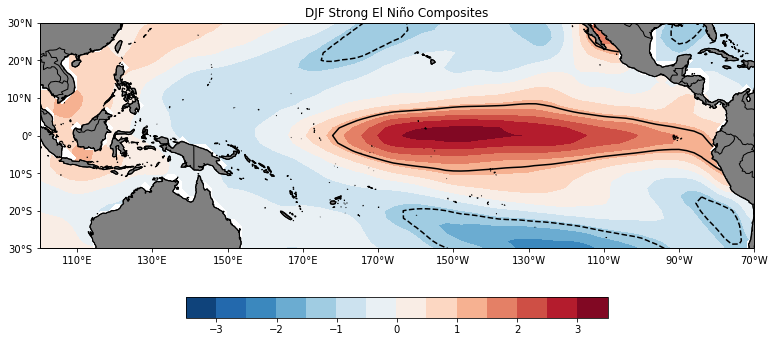

In [17]:
##----------------------- PLOTTING
plt.figure(figsize=(12,5))
inter = np.arange(-3.5, 4.0, 0.5)
interc = [-1.0, 1.0]

proj  =  ccrs.PlateCarree(central_longitude=180.)
ax = plt.axes(projection=proj)
y_lats  = np.arange(-40,40,10)
x_lons  = np.arange(-70,360,20)
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
tick_fs = 16
ax.set_xticks(x_lons, minor=False, crs=proj)
ax.set_yticks(y_lats, minor=False, crs=proj)
ax.add_feature(cf.LAND,color='grey')
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')

plt.contour(lon, lat, rt_endjf[0,:,:], interc,
            colors=('k',),linestyles=('--','-'),
            transform=ccrs.PlateCarree(),)


plt.contourf(lon, lat, ren_djf[0,:,:], inter,
             transform=ccrs.PlateCarree(),
             cmap=plt.get_cmap('RdBu_r'))

plt.colorbar(ax=ax, shrink=0.5, orientation='horizontal')
plt.title(u'DJF Strong El Niño Composites')

plt.tight_layout()
plt.show()

It looks like our last correlation field, which gives us some confidence here. Just to finish the subject, Statistical Significance remains again a topic worth of consideration.

You should feel encouraged to check the new and interesting 'False Discovery Rate'$^{2,3}$ test and to explore these concepts some more. No method is perfect, but it is good to make some reflection about what one is doing.

### NOTE: Some statisticians were intentionally harmed in the making of this notebook.

## REFERENCES

1 - Andreoli, Rita Valéria, et al. "The influence of different El Niño types on the South American rainfall." International Journal of Climatology 37.3 (2017): 1374-1390.

2 - Wilks, D. S. "On “field significance” and the false discovery rate." Journal of applied meteorology and climatology 45.9 (2006): 1181-1189.

3 - Wilks, Daniel S. "“The Stippling Shows Statistically Significant Grid Points”: How Research Results are Routinely Overstated and Overinterpreted, and What to Do about It." Bulletin of the American Meteorological Society 97.12 (2016): 2263-2273.